In [1]:
using Oceananigans
using Oceananigans.Units: minutes, hour, hours, day

grid = RectilinearGrid(GPU(), size=(64, 64), extent=(64, 64), halo=(3, 3), topology=(Periodic, Flat, Bounded))

64×1×64 RectilinearGrid{Float64, Periodic, Flat, Bounded} on GPU with 3×0×3 halo
├── Periodic x ∈ [0.0, 64.0)      regularly spaced with Δx=1.0
├── Flat y
└── Bounded  z ∈ [-64.0, 0.0]     regularly spaced with Δz=1.0

In [2]:
buoyancy_flux(x, t, params) = params.initial_buoyancy_flux * exp(-t^4 / (24 * params.shut_off_time^4))

buoyancy_flux_parameters = (initial_buoyancy_flux = 1e-8, # m² s⁻³
                                    shut_off_time = 2hours)

buoyancy_flux_bc = FluxBoundaryCondition(buoyancy_flux, parameters = buoyancy_flux_parameters)

FluxBoundaryCondition: ContinuousBoundaryFunction buoyancy_flux at (Nothing, Nothing, Nothing)

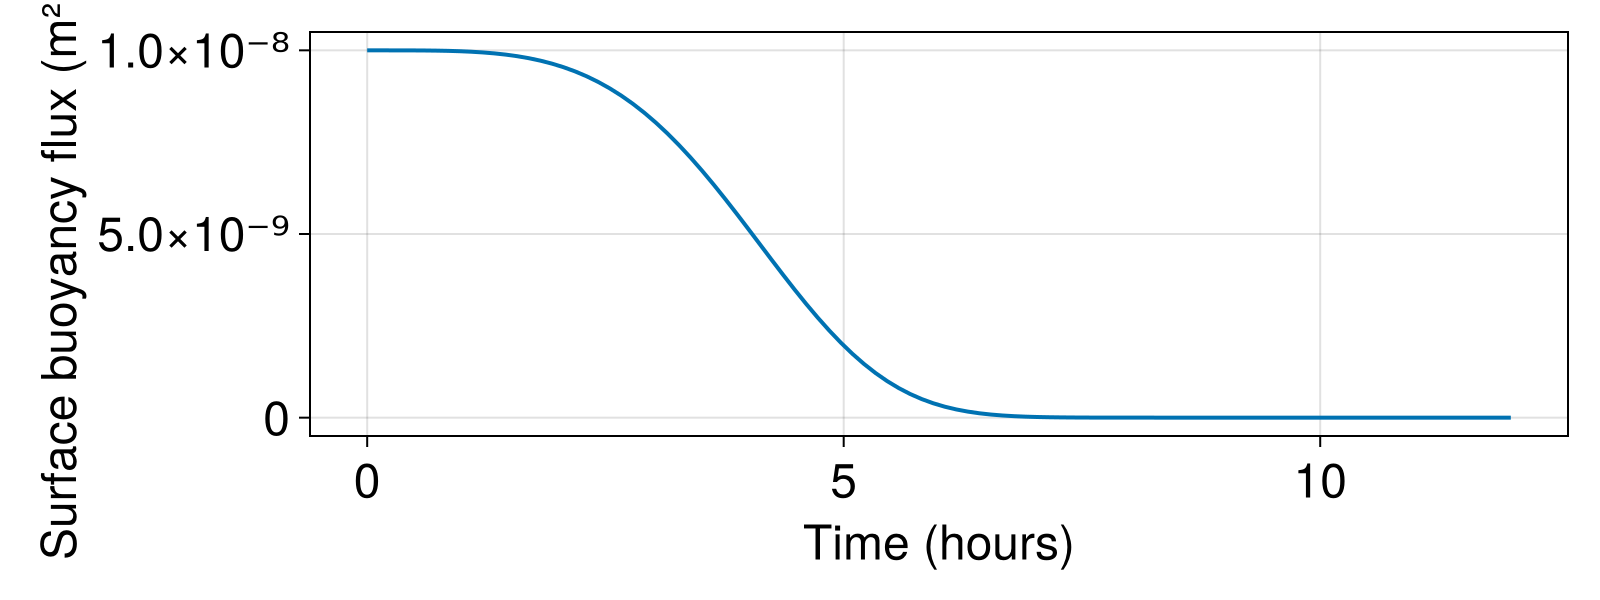

In [3]:
using CairoMakie
set_theme!(Theme(fontsize = 24, linewidth=2))

times = range(0, 12hours, length=100)

fig = Figure(size = (800, 300))
ax = Axis(fig[1, 1]; xlabel = "Time (hours)", ylabel = "Surface buoyancy flux (m² s⁻³)")

flux_time_series = [buoyancy_flux(0, t, buoyancy_flux_parameters) for t in times]
lines!(ax, times ./ hour, flux_time_series)

fig

In [4]:
N² = 1e-4 # s⁻²

buoyancy_gradient_bc = GradientBoundaryCondition(N²)

GradientBoundaryCondition: 0.0001

In [5]:
buoyancy_bcs = FieldBoundaryConditions(top = buoyancy_flux_bc, bottom = buoyancy_gradient_bc)

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── east: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── south: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── north: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)
├── bottom: GradientBoundaryCondition: 0.0001
├── top: FluxBoundaryCondition: ContinuousBoundaryFunction buoyancy_flux at (Nothing, Nothing, Nothing)
└── immersed: DefaultBoundaryCondition (FluxBoundaryCondition: Nothing)

In [6]:
growing_and_grazing(x, z, t, P, params) = (params.μ₀ * exp(z / params.λ) - params.m) * P

growing_and_grazing (generic function with 1 method)

In [7]:
plankton_dynamics_parameters = (μ₀ = 1/day,   # surface growth rate
                                 λ = 5,       # sunlight attenuation length scale (m)
                                 m = 0.1/day) # mortality rate due to virus and zooplankton grazing

(μ₀ = 1.1574074074074073e-5, λ = 5, m = 1.1574074074074074e-6)

In [8]:
plankton_dynamics = Forcing(growing_and_grazing, field_dependencies = :P,
                            parameters = plankton_dynamics_parameters)

ContinuousForcing{@NamedTuple{μ₀::Float64, λ::Int64, m::Float64}}
├── func: growing_and_grazing (generic function with 1 method)
├── parameters: (μ₀ = 1.1574074074074073e-5, λ = 5, m = 1.1574074074074074e-6)
└── field dependencies: (:P,)

In [9]:
model = NonhydrostaticModel(; grid,
                            advection = UpwindBiasedFifthOrder(),
                            timestepper = :RungeKutta3,
                            closure = ScalarDiffusivity(ν=1e-4, κ=1e-4),
                            coriolis = FPlane(f=1e-4),
                            tracers = (:b, :P), # P for Plankton
                            buoyancy = BuoyancyTracer(),
                            forcing = (; P=plankton_dynamics),
                            boundary_conditions = (; b=buoyancy_bcs))

NonhydrostaticModel{GPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 64×1×64 RectilinearGrid{Float64, Periodic, Flat, Bounded} on GPU with 3×0×3 halo
├── timestepper: RungeKutta3TimeStepper
├── advection scheme: Upwind Biased reconstruction order 5
├── tracers: (b, P)
├── closure: ScalarDiffusivity{ExplicitTimeDiscretization}(ν=0.0001, κ=(b=0.0001, P=0.0001))
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
└── coriolis: FPlane{Float64}(f=0.0001)

In [10]:
simulation = Simulation(model, Δt=2minutes, stop_time=24hours)

Simulation of NonhydrostaticModel{GPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 2 minutes
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 1 day
├── Stop iteration : Inf
├── Wall time limit: Inf
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [11]:
conjure_time_step_wizard!(simulation, cfl=1.0, max_Δt=2minutes)

In [12]:
using Printf

progress(sim) = @printf("Iteration: %d, time: %s, Δt: %s\n",
                        iteration(sim), prettytime(sim), prettytime(sim.Δt))

add_callback!(simulation, progress, IterationInterval(100))

In [13]:
outputs = (w = model.velocities.w,
           P = model.tracers.P,
           avg_P = Average(model.tracers.P, dims=(1, 2)))

simulation.output_writers[:simple_output] =
    JLD2OutputWriter(model, outputs,
                     schedule = TimeInterval(20minutes),
                     filename = "convecting_plankton.jld2",
                     overwrite_existing = true)

JLD2OutputWriter scheduled on TimeInterval(20 minutes):
├── filepath: .\convecting_plankton.jld2
├── 3 outputs: (w, P, avg_P)
├── array type: Array{Float64}
├── including: [:grid, :coriolis, :buoyancy, :closure]
├── file_splitting: NoFileSplitting
└── file size: 31.5 KiB

In [14]:
run!(simulation)

┌ Info: Initializing simulation...
└ @ Oceananigans.Simulations C:\Users\dadoi\.julia\packages\Oceananigans\M82LU\src\Simulations\run.jl:184


Iteration: 0, time: 0 seconds, Δt: 2 minutes


┌ Info:     ... simulation initialization complete (11.262 seconds)
└ @ Oceananigans.Simulations C:\Users\dadoi\.julia\packages\Oceananigans\M82LU\src\Simulations\run.jl:220
┌ Info: Executing initial time step...
└ @ Oceananigans.Simulations C:\Users\dadoi\.julia\packages\Oceananigans\M82LU\src\Simulations\run.jl:117
┌ Info:     ... initial time step complete (14.000 seconds).
└ @ Oceananigans.Simulations C:\Users\dadoi\.julia\packages\Oceananigans\M82LU\src\Simulations\run.jl:126


Iteration: 100, time: 3.333 hours, Δt: 2 minutes
Iteration: 200, time: 6.667 hours, Δt: 2 minutes
Iteration: 300, time: 10 hours, Δt: 2 minutes
Iteration: 400, time: 13.333 hours, Δt: 2 minutes
Iteration: 500, time: 16.667 hours, Δt: 2 minutes
Iteration: 600, time: 20 hours, Δt: 2 minutes
Iteration: 700, time: 23.333 hours, Δt: 2 minutes


┌ Info: Simulation is stopping after running for 31.093 seconds.
└ @ Oceananigans.Simulations C:\Users\dadoi\.julia\packages\Oceananigans\M82LU\src\Simulations\simulation.jl:202
┌ Info: Simulation time 1 day equals or exceeds stop time 1 day.
└ @ Oceananigans.Simulations C:\Users\dadoi\.julia\packages\Oceananigans\M82LU\src\Simulations\simulation.jl:203


In [15]:
filepath = simulation.output_writers[:simple_output].filepath

w_timeseries = FieldTimeSeries(filepath, "w")
P_timeseries = FieldTimeSeries(filepath, "P")
avg_P_timeseries = FieldTimeSeries(filepath, "avg_P")

times = w_timeseries.times
buoyancy_flux_time_series = [buoyancy_flux(0, t, buoyancy_flux_parameters) for t in times]
nothing # hide

In [16]:
using CairoMakie

@info "Making a movie about plankton..."

n = Observable(1)

title = @lift @sprintf("t = %s", prettytime(times[$n]))

wn = @lift w_timeseries[$n]
Pn = @lift P_timeseries[$n]
avg_Pn = @lift avg_P_timeseries[$n]

w_lim = maximum(abs, interior(w_timeseries))
w_lims = (-w_lim, w_lim)

P_lims = (0.95, 1.1)

fig = Figure(size = (1200, 1000))

ax_w = Axis(fig[2, 2]; xlabel = "x (m)", ylabel = "z (m)", aspect = 1)
ax_P = Axis(fig[3, 2]; xlabel = "x (m)", ylabel = "z (m)", aspect = 1)
ax_b = Axis(fig[2, 3]; xlabel = "Time (hours)", ylabel = "Buoyancy flux (m² s⁻³)", yaxisposition = :right)

ax_avg_P = Axis(fig[3, 3]; xlabel = "Plankton concentration (μM)", ylabel = "z (m)", yaxisposition = :right)
xlims!(ax_avg_P, 0.85, 1.3)

fig[1, 1:3] = Label(fig, title, tellwidth=false)

hm_w = heatmap!(ax_w, wn; colormap = :balance, colorrange = w_lims)
Colorbar(fig[2, 1], hm_w; label = "Vertical velocity (m s⁻¹)", flipaxis = false)

hm_P = heatmap!(ax_P, Pn; colormap = :matter, colorrange = P_lims)
Colorbar(fig[3, 1], hm_P; label = "Plankton 'concentration'", flipaxis = false)

lines!(ax_b, times ./ hour, buoyancy_flux_time_series; linewidth = 1, color = :black, alpha = 0.4)

b_flux_point = @lift Point2(times[$n] / hour, buoyancy_flux_time_series[$n])
scatter!(ax_b, b_flux_point; marker = :circle, markersize = 16, color = :black)
lines!(ax_avg_P, avg_Pn)

fig

┌ Info: Making a movie about plankton...
└ @ Main c:\Users\dadoi\DataspellProjects\VS Code\Julia-Weather-Simulations\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:3


ArgumentError: ArgumentError:     Conversion failed for Heatmap (With conversion trait CellGrid()) with args: Tuple{Field{Center, Center, Face, Nothing, RectilinearGrid{Float64, Periodic, Flat, Bounded, Float64, Float64, Float64, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}, CPU}, Tuple{UnitRange{Int64}, UnitRange{Int64}, UnitRange{Int64}}, OffsetArrays.OffsetArray{Float64, 3, SubArray{Float64, 3, Array{Float64, 4}, Tuple{Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Base.Slice{Base.OneTo{Int64}}, Int64}, true}}, Float64, FieldBoundaryConditions{Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}, Nothing, Oceananigans.Fields.FieldBoundaryBuffers{Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}}} .
    Heatmap requires to convert to argument types Tuple{AbstractVector{T} where T<:Real, AbstractVector{T} where T<:Real, AbstractMatrix{<:Union{Float32, Float64, ColorTypes.Colorant}}}, which convert_arguments didn't succeed in.
    To fix this overload convert_arguments(P, args...) for Heatmap or CellGrid() and return an object of type Tuple{AbstractVector{T} where T<:Real, AbstractVector{T} where T<:Real, AbstractMatrix{<:Union{Float32, Float64, ColorTypes.Colorant}}}.`


In [18]:
frames = 1:length(times)

@info "Making an animation of convecting plankton..."

record(fig, "convecting_plankton.mp4", frames, framerate=8) do i
    n[] = i
end

┌ Info: Making an animation of convecting plankton...
└ @ Main c:\Users\dadoi\DataspellProjects\VS Code\Julia-Weather-Simulations\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sZmlsZQ==.jl:3


"convecting_plankton.mp4"